<div style="display: flex; align-items: center;">
  <div style="flex: 1; max-width: 70%;">
    MSCI is a Python package designed to evaluate the information content of peptide fragmentation spectra. Our objective was to compute an information-content index for all peptides within a given proteome. This would allow us to devise data acquisition and analysis strategies that generate and prioritize the most informative fragment ions for peptide quantification.
  </div>
  <img src="https://github.com/proteomicsunitcrg/MSCI/raw/main/docs/MSCI_logo.png" width="300" style="margin-left: 20px;">
</div>


#Download MSCI package and necessary installations

In [4]:
#!git clone https://github.com/proteomicsunitcrg/MSCI.git
#! pip install matchms
# do not restart session if asked (press cancel matchms since probably you already have matchms installed )
#%cd MSCI
#import sys
#sys.path.append('/content/MSCI')


In [5]:
! pip install MSCI==0.2.0
! pip install biopython
! pip install matchms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━

# Import


In [6]:
from MSCI.Preprocessing.Koina import PeptideProcessor
from MSCI.Grouping_MS1.Grouping_mw_irt import process_peptide_combinations
from MSCI.Preprocessing.read_msp_file import read_msp_file
from MSCI.Similarity.spectral_angle_similarity import process_spectra_pairs
from MSCI.data.digest import parse_fasta_and_digest, tryptic_digest, peptides_to_csv
from matchms.importing import load_from_msp
import random
import numpy as np
import pandas as pd

# Generate predicted dataset

## Parse fasta file

In [9]:
import requests

# URL of the FASTA file
url = "https://raw.githubusercontent.com/proteomicsunitcrg/MSCI/main/tutorial/sp_human_2023_04.fasta"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    fasta_file = "sp_human_2023_04.fasta"  # Save as a local file
    with open(fasta_file, "w") as f:
        f.write(response.text)
else:
    raise Exception(f"Failed to download file: {response.status_code}")

# Now pass the local file path to your function
result = parse_fasta_and_digest(fasta_file, digest_type="trypsin")

# Save output
peptides_to_csv(result, "random_tryptic_peptides.txt")


###  Download the list of peptides of interest


In [ ]:
import random

# List of standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Function to generate a single tryptic peptide
def generate_tryptic_peptide(min_length=8, max_length=20):
    length = random.randint(min_length, max_length - 1)
    peptide = ''.join(random.choices(amino_acids, k=length))
    peptide += random.choice('KR')
    return peptide

# Generate a list of 90 random tryptic peptides
tryptic_peptides = [generate_tryptic_peptide() for _ in range(90)]

# Generate 5 pairs of peptides that are permutations of each other and print them
permuted_pairs = []
for _ in range(5):
    peptide = generate_tryptic_peptide()
    # Ensure the peptide has at least 2 characters to swap
    if len(peptide) < 2:
        continue
    # Select two different positions to swap
    pos1, pos2 = random.sample(range(len(peptide) - 1), 2)
    permuted_peptide_list = list(peptide)
    permuted_peptide_list[pos1], permuted_peptide_list[pos2] = permuted_peptide_list[pos2], permuted_peptide_list[pos1]
    permuted_peptide = ''.join(permuted_peptide_list)
    tryptic_peptides.append(peptide)
    tryptic_peptides.append(permuted_peptide)
    permuted_pairs.append((peptide, permuted_peptide))

# Ensure the last peptide meets the length requirement
last_peptide_length = random.randint(5, 20)
last_peptide = ''.join(random.choices(amino_acids, k=last_peptide_length))
tryptic_peptides[-1] = last_peptide

# Shuffle the list to mix the pairs with the other peptides
random.shuffle(tryptic_peptides)
# Save the peptides to a file
with open('random_tryptic_peptides.txt', 'w') as f:
    for peptide in tryptic_peptides:
        f.write(f"{peptide}\n")


print("Generated 100 random tryptic peptides with permutation pairs and saved to 'random_tryptic_peptides.txt'.")


Generated 100 random tryptic peptides with permutation pairs and saved to 'random_tryptic_peptides.txt'.


### Predict with Koina

#### If available your own list of peptides

In [ ]:
processor = PeptideProcessor(
    input_file="random_tryptic_peptides.txt",
    collision_energy=30,
    charge=2,
    model_intensity="Prosit_2020_intensity_HCD",
    model_irt="Prosit_2019_irt"
)

processor.process('random_tryptic_peptides.msp')

# Load dataset


In [ ]:
# You can use your own spectra
File= 'random_tryptic_peptides.msp'
spectra = list(load_from_msp(File))

2024-08-22 13:30:02,993:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,001:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,008:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,014:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,020:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,026:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,032:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,038:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,043:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,046:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,050:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,055:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,059:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,062:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,066:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,075:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,079:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,082:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,086:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,089:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,094:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,098:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,102:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,105:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,108:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,113:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,116:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,120:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,123:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,126:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,130:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,135:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,139:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,143:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,146:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,150:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,153:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,157:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,163:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,167:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,170:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,174:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,178:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,181:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,184:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,187:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,191:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,195:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,199:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,203:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,207:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,210:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,213:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,216:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,220:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,223:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,227:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,230:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,234:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,242:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,246:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,251:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,254:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,258:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,261:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,264:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,268:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,272:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,275:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,278:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,282:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,285:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,289:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,294:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,297:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,300:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,304:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,307:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,310:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,314:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,317:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,321:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,324:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,328:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,332:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,336:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,343:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,347:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,350:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,354:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,359:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,362:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,366:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,370:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,374:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,377:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,381:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,384:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,388:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2024-08-22 13:30:03,391:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


# Group within MS1 tolerance

In [ ]:
mz_tolerance = 1
irt_tolerance = 5


mz_irt_df = read_msp_file(File)
Groups_df = process_peptide_combinations(mz_irt_df, mz_tolerance, irt_tolerance, use_ppm=False)

Groups_df

Results DataFrame Columns: Index(['index1', 'index2', 'peptide 1', 'peptide 2', 'm/z  1', 'm/z 2',
       'iRT 1', 'iRT 2'],
      dtype='object')


,index1,index2,peptide 1,peptide 2,m/z 1,m/z 2,iRT 1,iRT 2
0,2,15,FTCQIAHVCPHFNNPK/2,IDIDKYGKAISACHPPK/2,928.440166,928.490379,50.206707,49.247311
1,8,19,RTNYPMFEYHK/2,TLPRMTKYYGVR/2,743.350811,742.905754,35.316872,34.458534
2,46,73,HQEEAMMFHPLMNKNNTFR/2,QSAICREAEQTKFNMVSKFR/2,1188.045732,1187.093736,61.910671,62.716576


# Calculate similarity within fragment tolerance


In [ ]:
Groups_df.columns = Groups_df.columns.str.strip()
index_array = Groups_df[['index1','index2']].values.astype(int)
result = process_spectra_pairs(index_array, spectra,  mz_irt_df, tolerance =0, ppm=10)
result.to_csv("output.csv", index=False)
result

0.002814877157520823
0.0
0.0025644450471453695


,index1,index2,peptide 1,peptide 2,m/z 1,m/z 2,iRT 1,iRT 2,similarity_score
0,2,15,FTCQIAHVCPHFNNPK/2,IDIDKYGKAISACHPPK/2,928.440166,928.490379,50.206707,49.247311,0.002815
1,8,19,RTNYPMFEYHK/2,TLPRMTKYYGVR/2,743.350811,742.905754,35.316872,34.458534,0.000000
2,46,73,HQEEAMMFHPLMNKNNTFR/2,QSAICREAEQTKFNMVSKFR/2,1188.045732,1187.093736,61.910671,62.716576,0.002564


# Plot results

### Plot spectra of interest using matchms

Name    MRIGTPEPWSTQSDKR/2
MW              944.970342
iRT              41.258202
Name: 19, dtype: object
Name    QAIMSISYHSCYNMFR/2
MW              975.936599
iRT              93.540787
Name: 36, dtype: object


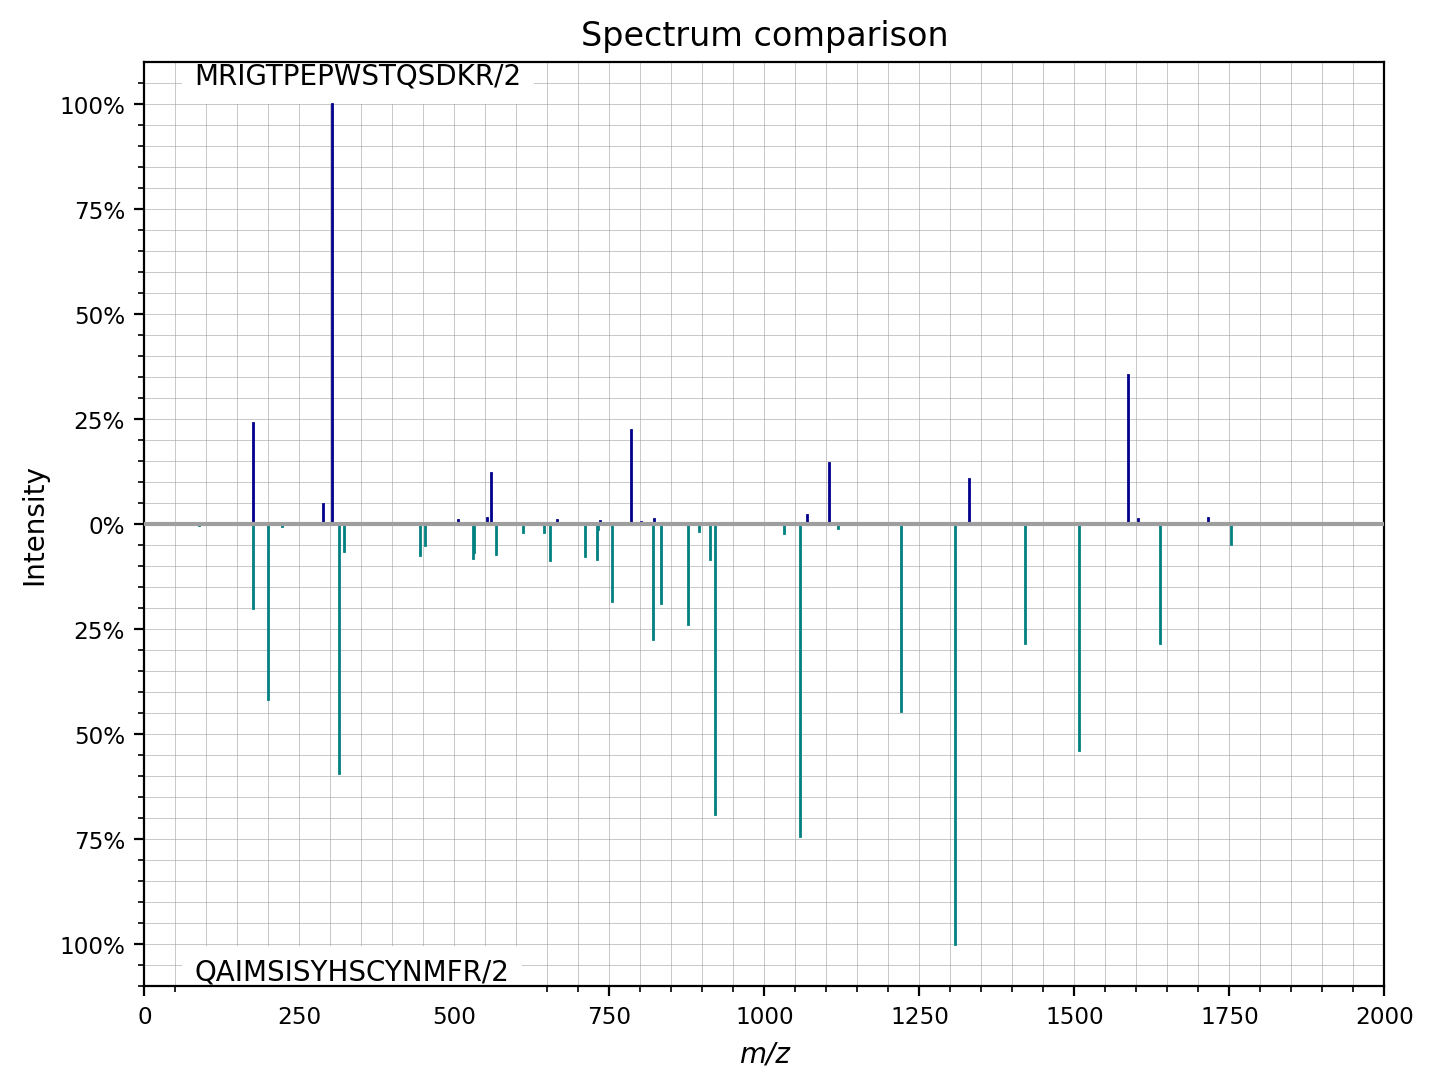

In [ ]:
import matplotlib.pyplot as plt
print(mz_irt_df.iloc[19])
print(mz_irt_df.iloc[36])
spectra[19].plot_against(spectra[36])
plt.savefig('spectra_comparison.png')